# Problem Statement
# Perform sentimental analysis:

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import string
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score,classification_report
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import dataset
tweets=pd.read_csv(r'C:/Users/admin/OneDrive/Desktop/Elon_musk.csv',encoding='cp1252')
tweets

,Unnamed: 0,Text
0,1,@kunalb11 I’m an alien
1,2,@ID_AA_Carmack Ray tracing on Cyberpunk with H...
2,3,@joerogan @Spotify Great interview!
3,4,@gtera27 Doge is underestimated
4,5,@teslacn Congratulations Tesla China for amazi...
...,...,...
1994,1995,"@flcnhvy True, it sounds so surreal, but the n..."
1995,1996,@PPathole Make sure to read ur terms &amp; con...
1996,1997,@TeslaGong @PPathole Samwise Gamgee
1997,1998,@PPathole Altho Dumb and Dumber is <U+0001F525...


In [3]:
#rename column and drop unwanted column
tweets.drop(['Unnamed: 0'], inplace= True, axis= 1)
tweets.rename({'Text':'Tweets'},axis=1,inplace=True)
tweets

,Tweets
0,@kunalb11 I’m an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...
2,@joerogan @Spotify Great interview!
3,@gtera27 Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...
...,...
1994,"@flcnhvy True, it sounds so surreal, but the n..."
1995,@PPathole Make sure to read ur terms &amp; con...
1996,@TeslaGong @PPathole Samwise Gamgee
1997,@PPathole Altho Dumb and Dumber is <U+0001F525...


# EDA on data

In [4]:
# add lenth of the tweets to dataset
tweets['Len']=tweets['Tweets'].apply(len)
tweets

,Tweets,Len
0,@kunalb11 I’m an alien,22
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,82
2,@joerogan @Spotify Great interview!,35
3,@gtera27 Doge is underestimated,31
4,@teslacn Congratulations Tesla China for amazi...,104
...,...,...
1994,"@flcnhvy True, it sounds so surreal, but the n...",144
1995,@PPathole Make sure to read ur terms &amp; con...,77
1996,@TeslaGong @PPathole Samwise Gamgee,35
1997,@PPathole Altho Dumb and Dumber is <U+0001F525...,59


In [5]:
tweets.shape

(1999, 2)

In [6]:
#information of data set 
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweets  1999 non-null   object
 1   Len     1999 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [7]:
#describe the data 
tweets.describe()

,Len
count,1999.000000
mean,78.442721
std,44.617029
min,3.000000
25%,39.000000
50%,68.000000
75%,129.000000
max,191.000000


In [8]:
#lets see maximum lenth of tweet
tweets[tweets['Len']==191].iloc[0,0]

'RT @Tesla: Big updates in <U+0001F1E8><U+0001F1E6> \n\n– Trans-Canada Supercharging <U+2705> \n– Model Y deliveries <U+2705> \n– Leasing for Model Y &amp; Model 3 <U+0001F3AF>\nhttps://t.co/gyFBE…'

# Data Exploration 

array([[<Axes: title={'center': 'Len'}>]], dtype=object)

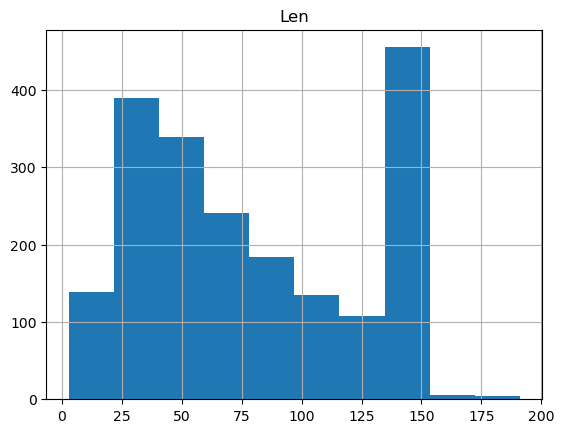

In [9]:
#plot the histogram
tweets.hist()

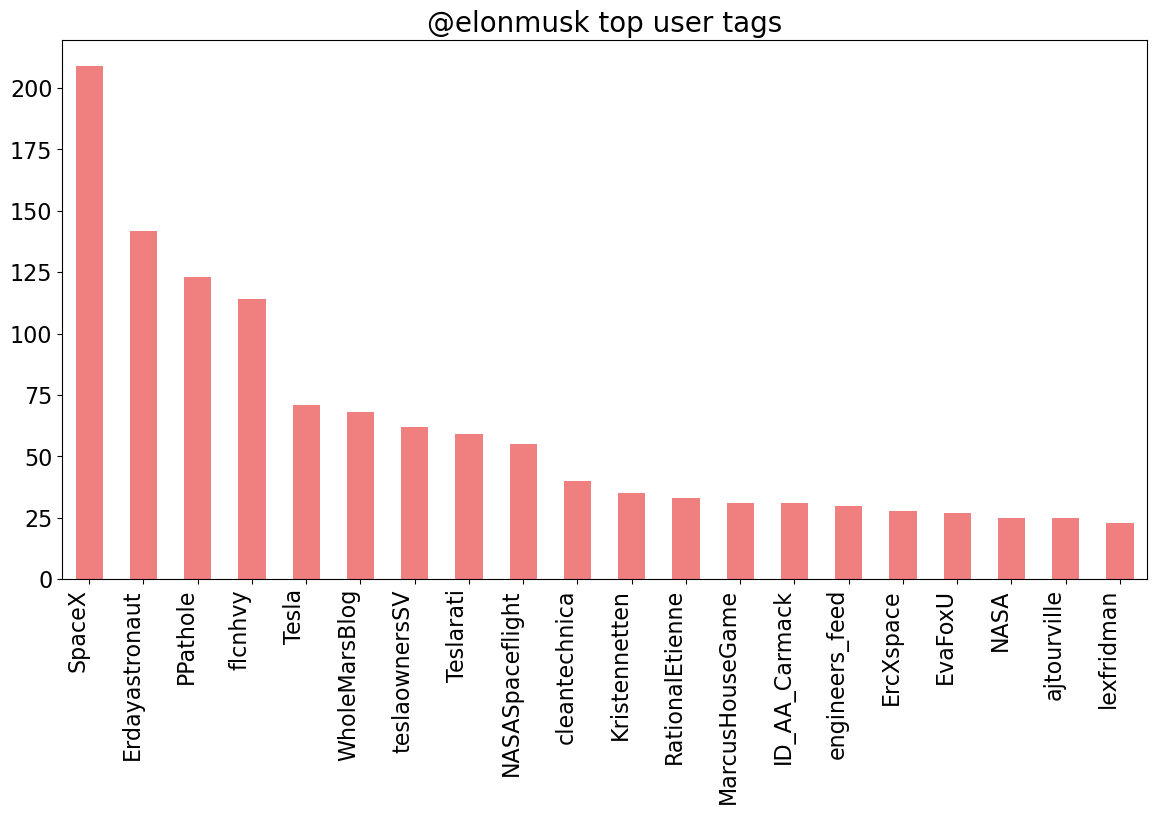

In [10]:
import itertools

c = list(itertools.chain(*tweets.Tweets.map(lambda t: [handle.replace(":", "")[1:] for handle in t.split(" ")
                                                     if '@' in handle.replace(":", "")]).tolist()))

pd.Series(c).value_counts().head(20).plot.bar(figsize=(14, 7), fontsize=16, color='lightcoral')
plt.gca().set_title('@elonmusk top user tags', fontsize=20)
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=90, ha='right', fontsize=16)
pass

# Creating function for Remove the punctuation and Stop words

In [11]:
#Creating function for Remove the punctuation and Stop words
def cleanwords(title):
    no_punc= [x for x in title if x not in string.punctuation]
    no_pun=''.join(no_punc)
    return [x for x in no_pun.split() if x.lower() not in stopwords.words('english')]

In [12]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [13]:
tweets['Tweets'] = tweets['Tweets'].apply(lambda x: clean_text(x))
tweets.head(10)

,Tweets,Len
0,i’m an alien,22
1,idaacarmack ray tracing on cyberpunk with hdr ...,82
2,joerogan spotify great interview,35
3,doge is underestimated,31
4,teslacn congratulations tesla china for amazin...,104
5,happy new year of the ox,49
6,frodo was the underdogeall thought he would fa...,96
7,owensparks flcnhvy haha thanks,46
8,flcnhvy indeed tweets definitely do not repre...,89
9,the most entertaining outcome is the most likely,48


# Basic Feature Extaction
# Count vectoriser tells the frequency of a word.

In [14]:
#applying CountVetorizer
count_vec= CountVectorizer(analyzer=cleanwords,ngram_range=(1,1))

In [15]:
count_vec

CountVectorizer(analyzer=<function cleanwords at 0x000001F0D8393400>)

In [16]:
# Transform the Tweets into numbers
count_vectr=count_vec.fit_transform(tweets['Tweets'])
count_vectr

<1999x4588 sparse matrix of type '<class 'numpy.int64'>'
	with 13279 stored elements in Compressed Sparse Row format>

In [17]:
count_vec.get_feature_names_out()

array(['aber', 'able', 'aboard', ..., '…', '…yeah', '…you’re'],
      dtype=object)

In [18]:

word_freq_df = pd.DataFrame({'term': count_vec.get_feature_names_out(), 'occurrences':np.asarray(count_vectr.sum(axis=0)).ravel().tolist()})
word_freq_df['frequency'] = word_freq_df['occurrences']/np.sum(word_freq_df['occurrences'])
word_freq_df.head(10)

,term,occurrences,frequency
0,aber,1,0.000074
1,able,6,0.000446
2,aboard,1,0.000074
3,abort,3,0.000223
4,abo…,1,0.000074
5,absence,1,0.000074
6,absolute,1,0.000074
7,absolutely,15,0.001115
8,absorb,1,0.000074
9,absorption,1,0.000074


# TFIDF - Term frequency inverse Document Frequency

In [19]:
tf= TfidfTransformer()
tf

TfidfTransformer()

In [20]:
tf_id=tf.fit_transform(count_vectr)
tf_id

<1999x4588 sparse matrix of type '<class 'numpy.float64'>'
	with 13279 stored elements in Compressed Sparse Row format>

In [21]:
from textblob import TextBlob

In [22]:
from textblob import TextBlob
tweets['Tweets'][:5].apply(lambda x: str(TextBlob(x).correct()))

0                                         i’m an alien
1    idaacarmack ray tracing on cyberpunk with her ...
2                     joerogan specify great interview
3                               done is underestimated
4    teslacn congratulations tell china for amazing...
Name: Tweets, dtype: object

# N-grams
#N-grams are the combination of multiple words used together. Ngrams with N=1 are called unigrams. Similarly, bigrams (N=2), trigrams (N=3) and so on can also be used.

In [23]:
TextBlob(tweets['Tweets'][3]).ngrams(1)

[WordList(['doge']), WordList(['is']), WordList(['underestimated'])]

In [24]:
TextBlob(tweets['Tweets'][3]).ngrams(2)

[WordList(['doge', 'is']), WordList(['is', 'underestimated'])]

In [25]:
TextBlob(tweets['Tweets'][3]).ngrams(3)

[WordList(['doge', 'is', 'underestimated'])]

# Bi-gram

In [26]:
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2), max_features=2000).fit(corpus) #for tri-gram, put ngram_range=(3,3)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [27]:
top2_words = get_top_n2_words(tweets["Tweets"], n=200) #top 200
top2_df = pd.DataFrame(top2_words)
top2_df.columns = ["Bi-gram", "Freq"]
top2_df.head(11)

,Bi-gram,Freq
0,rt spacex,71
1,will be,51
2,of the,47
3,in the,36
4,this is,35
5,to the,28
6,to be,28
7,we re,26
8,is the,24
9,should be,22


# Bi-gram plot

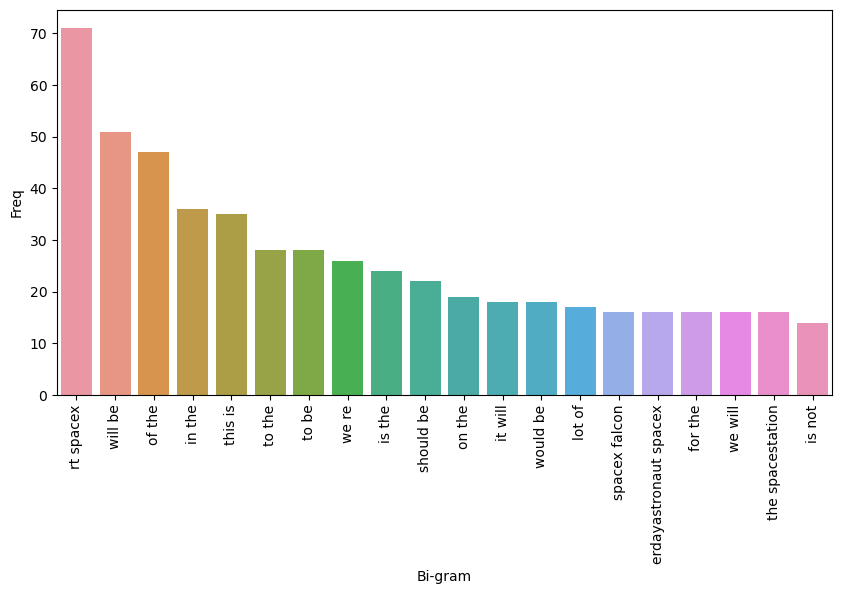

In [28]:
top20_bigram = top2_df.iloc[0:20,:]
fig = plt.figure(figsize = (10, 5))
plot = sns.barplot(x=top20_bigram["Bi-gram"],y=top20_bigram["Freq"])
plot.set_xticklabels(rotation=90,labels = top20_bigram["Bi-gram"]);

# Tri-gram

In [29]:
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [30]:
top3_words = get_top_n3_words(tweets["Tweets"], n=200)
top3_df = pd.DataFrame(top3_words)
top3_df.columns = ["Tri-gram", "Freq"]
top3_df.head(11)

,Tri-gram,Freq
0,rt spacex falcon,16
1,falcon first stage,9
2,to the spacestation,9
3,it will be,8
4,spacex falcon first,8
5,thesheetztweetz waemd spacex,8
6,of course still,7
7,course still love,7
8,still love you,7
9,one of the,7


# Tri-gram plot

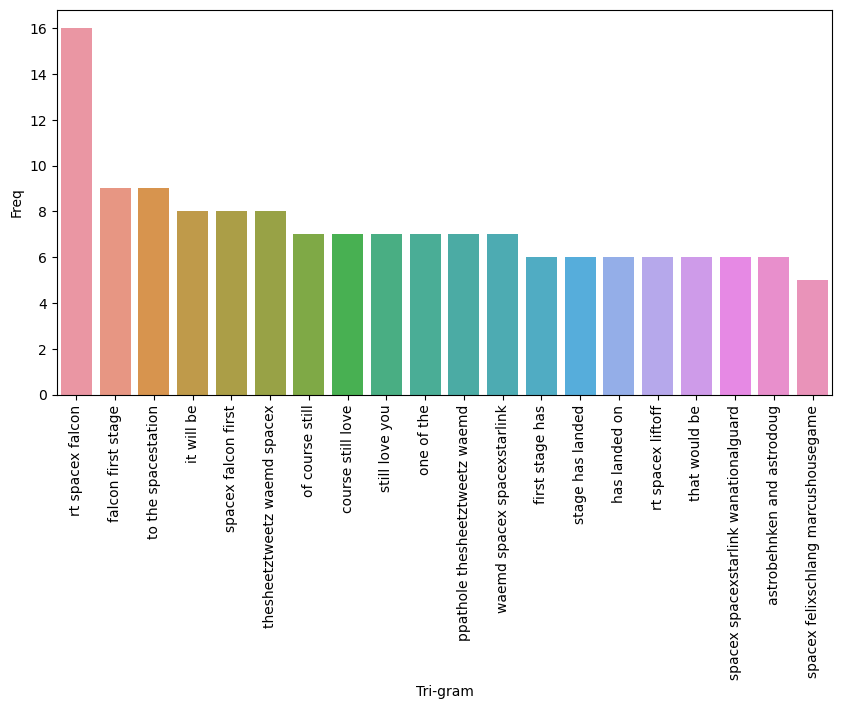

In [31]:
import seaborn as sns
top20_trigram = top3_df.iloc[0:20,:]
fig = plt.figure(figsize = (10, 5))
plot = sns.barplot(x=top20_trigram["Tri-gram"],y=top20_trigram["Freq"])
plot.set_xticklabels(rotation=90,labels = top20_trigram["Tri-gram"]);

# Creating a Worlcloud

In [32]:
string_Total = " ".join(tweets["Tweets"])

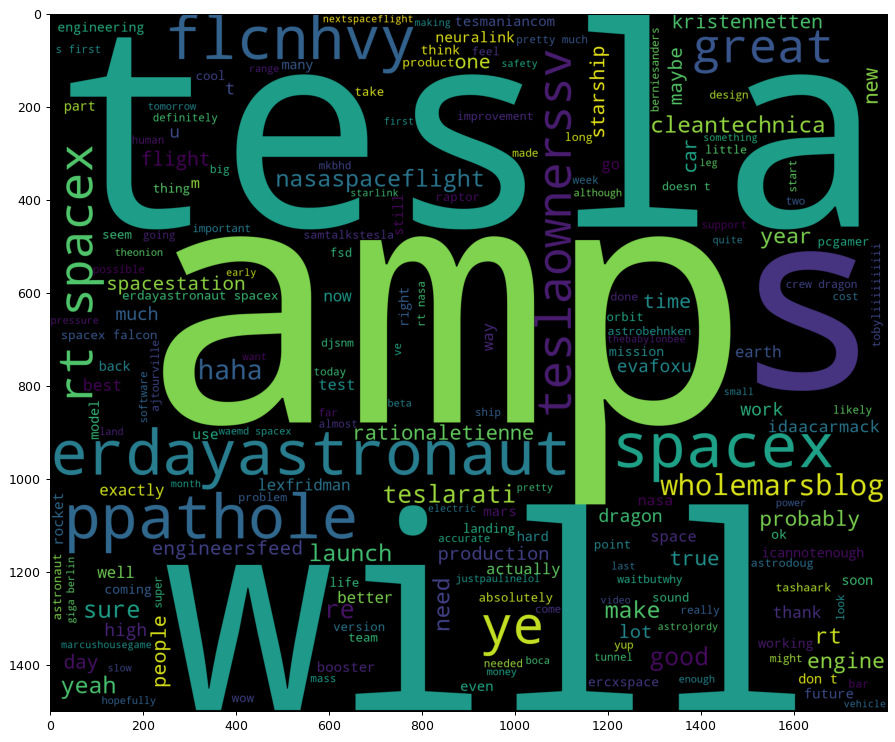

In [33]:
#wordcloud for entire corpus
from wordcloud import WordCloud
plt.figure(figsize=(12,12),dpi=90)
wordcloud_stw = WordCloud(background_color= 'black', width = 1800, height = 1500).generate(string_Total)
plt.imshow(wordcloud_stw);


In [34]:
from textblob import TextBlob

# Get The Subjectivity
def sentiment_analysis(ds):
    sentiment = TextBlob(ds["Tweets"]).sentiment
    return pd.Series([sentiment.subjectivity, sentiment.polarity])

# Adding Subjectivity & Polarity
tweets[["subjectivity", "polarity"]] = tweets.apply(sentiment_analysis, axis=1)
tweets.head(11)

,Tweets,Len,subjectivity,polarity
0,i’m an alien,22,0.750000,-0.250000
1,idaacarmack ray tracing on cyberpunk with hdr ...,82,0.000000,0.000000
2,joerogan spotify great interview,35,0.750000,0.800000
3,doge is underestimated,31,0.000000,0.000000
4,teslacn congratulations tesla china for amazin...,104,0.366667,0.275000
5,happy new year of the ox,49,0.727273,0.468182
6,frodo was the underdogeall thought he would fa...,96,0.500000,0.500000
7,owensparks flcnhvy haha thanks,46,0.250000,0.200000
8,flcnhvy indeed tweets definitely do not repre...,89,0.500000,0.000000
9,the most entertaining outcome is the most likely,48,0.675000,0.375000


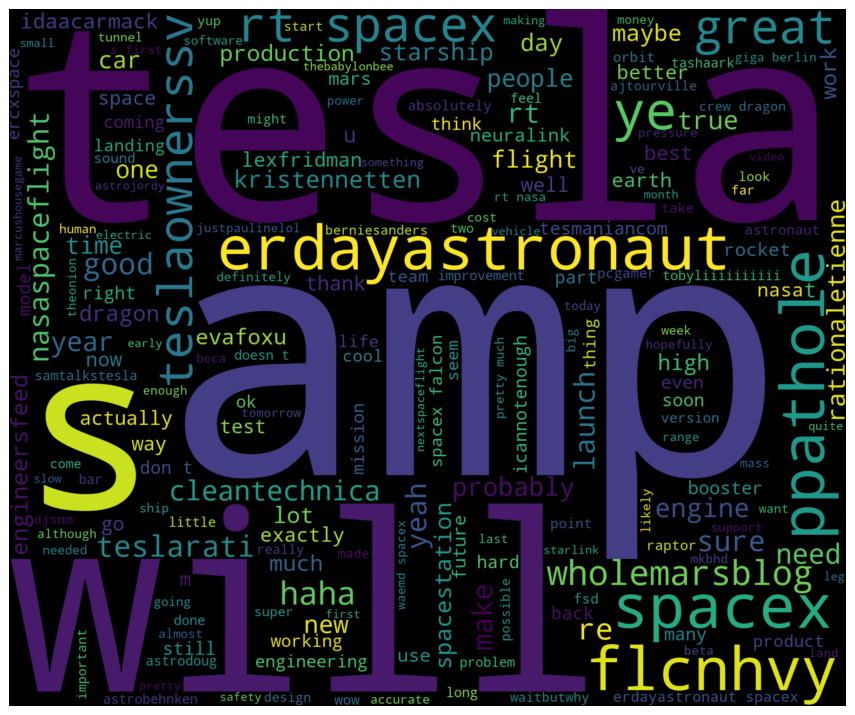

In [35]:
# Creating a word cloud for all words
allwords = " ".join([twts for twts in tweets["Tweets"]])
wordCloud = WordCloud(width = 1800, height = 1500, random_state = 21).generate(allwords)
plt.figure(figsize=(12,12), dpi=90)
plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis("off")
plt.show()


In [36]:
# 1 way
def fetch_sentiment_using_SIA(text):
    sid = SentimentIntensityAnalyzer()
    polarity_scores = sid.polarity_scores(text)
    return 'neg' if polarity_scores['neg'] > polarity_scores['pos'] else 'pos'

tweets['analysis1']=tweets['Tweets'].apply(fetch_sentiment_using_SIA)


In [37]:
# 2 way
def fetch_sentiment_using_textblob(text):
    analysis = TextBlob(text)
    return 'pos' if analysis.sentiment.polarity >= 0 else 'neg'
tweets['analysis2']=tweets['Tweets'].apply(fetch_sentiment_using_textblob)

In [38]:
# Compute The Negative, Neutral, Positive Analysis
def analysis(score):
    if score < 0:
        return "Negative"
    elif score == 0:
        return "Neutral"
    else:
        return "Positive"
    
# Create a New Analysis Column
tweets["analysis"] = tweets["polarity"].apply(analysis)

In [39]:
tweets

,Tweets,Len,subjectivity,polarity,analysis1,analysis2,analysis
0,i’m an alien,22,0.750000,-0.250000,pos,neg,Negative
1,idaacarmack ray tracing on cyberpunk with hdr ...,82,0.000000,0.000000,pos,pos,Neutral
2,joerogan spotify great interview,35,0.750000,0.800000,pos,pos,Positive
3,doge is underestimated,31,0.000000,0.000000,neg,pos,Neutral
4,teslacn congratulations tesla china for amazin...,104,0.366667,0.275000,pos,pos,Positive
...,...,...,...,...,...,...,...
1994,flcnhvy true it sounds so surreal but the nega...,144,0.508333,0.111111,neg,pos,Positive
1995,ppathole make sure to read ur terms amp condit...,77,0.888889,0.500000,pos,pos,Positive
1996,teslagong ppathole samwise gamgee,35,0.000000,0.000000,pos,pos,Neutral
1997,ppathole altho dumb and dumber is,59,0.500000,-0.375000,neg,neg,Negative


In [40]:
positive_tweets = tweets[tweets['analysis'] == 'Positive']
negative_tweets = tweets[tweets['analysis'] == 'Negative']
neutral_tweets = tweets[tweets['analysis'] == 'Neutral']

print('positive tweets:')
for i, row in positive_tweets[:5].iterrows():
    print(' -' + row['Tweets'],'\n')

print('negative tweets:')
for i, row in negative_tweets[:5].iterrows():
    print(' -' + row['Tweets'],'\n')
    
print('neutral tweets:')
for i, row in neutral_tweets[:5].iterrows():
    print(' -' + row['Tweets'],'\n')

positive tweets:
 -joerogan spotify great interview 

 -teslacn congratulations tesla china for amazing execution last year now on to the next for even more 

 -happy new year of the ox  

 -frodo was the underdogeall thought he would failhimself most of all  

 -owensparks flcnhvy  haha thanks  

negative tweets:
 - i’m an alien 

 -freewalletorg your app sucks 

 -rationaletienne adamklotz starlink is a staggeringly difficult technical amp economic endeavor however if we don…  

 -rationaletienne adamklotz spacex needs to pass through a deep chasm of negative cash flow over the next year or…  

 -sruhle everyone at tesla receives stock my comp is all stockoptions which i do not take off the table that’s what you’re missing 

neutral tweets:
 -idaacarmack ray tracing on cyberpunk with hdr is nextlevel have you tried it 

 - doge is underestimated 

 -flcnhvy  indeed tweets definitely do not represent realworld time allocation 

 -givedirectly just sent some 

 -just agree to do clubho

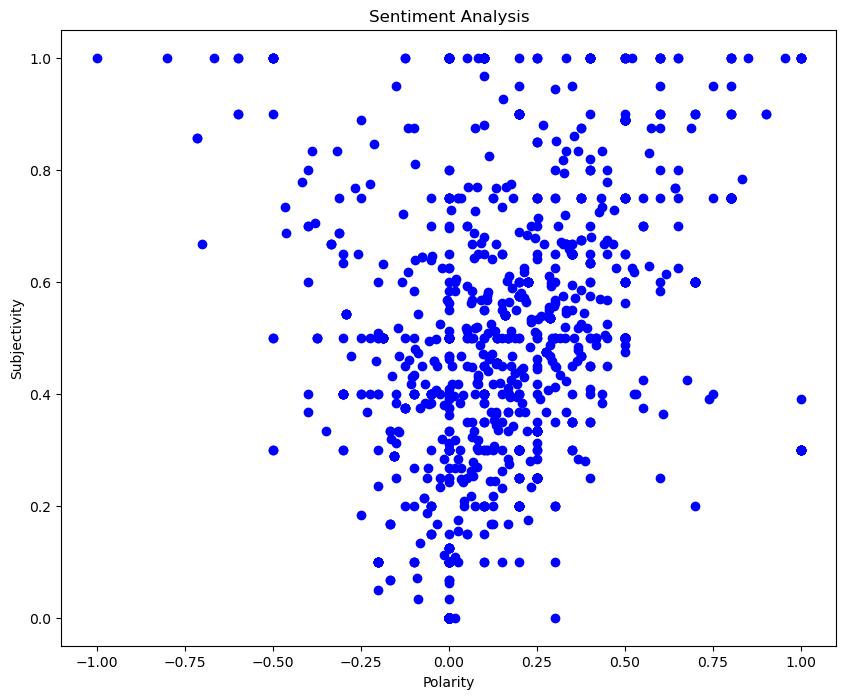

In [41]:
plt.figure(figsize=(10, 8))

for i in range(0, tweets.shape[0]):
    plt.scatter(tweets["polarity"][i], tweets["subjectivity"][i], color = "blue")

plt.title("Sentiment Analysis") # Add The Graph Title
plt.xlabel("Polarity") # Add The X-Label
plt.ylabel("Subjectivity") # Add The Y-Label
plt.show() # Showing The Graph

In [42]:
tweets['analysis'].value_counts()

Neutral     903
Positive    880
Negative    216
Name: analysis, dtype: int64